In [1]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt

In [55]:
def expb_gen(c1, c2, t0, t1=ca.inf):
    def exp_bas(t):
        return ca.if_else(ca.logic_and((t0<=t),(t<t1)), c1 * ca.exp(c2 * (t - t0)), 0)
    return exp_bas

In [56]:
cs_0 = ca.SX.sym('c', 2)
ts_0 = ca.SX.sym('t0', 1)

In [57]:
exp_0 = expb_gen(cs_0[0], cs_0[1], ts_0)

In [58]:
exp_0(1)

SX(@1=1, (((t0<=@1)&&@1)?(c_0*exp((c_1*(@1-t0)))):0))

In [59]:
t = ca.SX.sym('t', 1)

In [60]:
ca.jacobian(exp_0(t), t)

SX((((t0<=t)&&(t<inf))?(c_0*(exp((c_1*(t-t0)))*c_1)):0))

Each basis function can be expressed as

$a_i e ^{b_i (t - t_i)}$

If we want continuity in our states we impose that successive functions must be equal at the $t_i$s

$a_i e ^{b_i (t_i - t_i)} = a_{i-1} e ^ {b_{i-1} (t_i - t_{i-1})}$

which restricts $a_i$:

$a_i = a_{i-1} e^ {b_{i-1} (t_i - t_{i-1})}$

which can be applied recursively to give

$$
\begin{aligned}
a_i &= a_0 \prod_{j=1}^{i} e^{b_{j-1} (t_j - t_{j-1})}\\
&= a_0 e^{\sum_{j=1}^{i} b_{j-1} (t_j - t_{j-1})}
\end{aligned}
$$

In [61]:
def full_exp_basis_gen(ks):
    # give a vector of knot locations (t_i); get a simple symbolic exponentials basis
    a0 = ca.SX.sym('a_0')
    bs = ca.SX.sym('b', len(ks))
    a_s = [a0]
    a = a0
    for kj0, kj1, b in zip(ks[:-1], ks[1:], bs.nz):
        a = a * ca.exp(b*(kj1-kj0))
        a_s.append(a)
    ks.append(ca.inf)
    return a0, bs, [expb_gen(ai, bi, ti, tj) for ai, bi, ti, tj in zip(a_s, bs.nz, ks, ks[1:])]

In [62]:
a0var, bvars, eight_basis = full_exp_basis_gen([0, 1, 2, 3, 4, 5, 6, 7])

In [63]:
basis_value = ca.hcat([ca.vcat([ebfn(ti) for ebfn in eight_basis]) for ti in np.linspace(0, 8, 91)])

In [64]:
bfull_fn = ca.Function('bfull', [a0var, bvars], [basis_value])

In [65]:
%matplotlib notebook

<IPython.core.display.Javascript object>


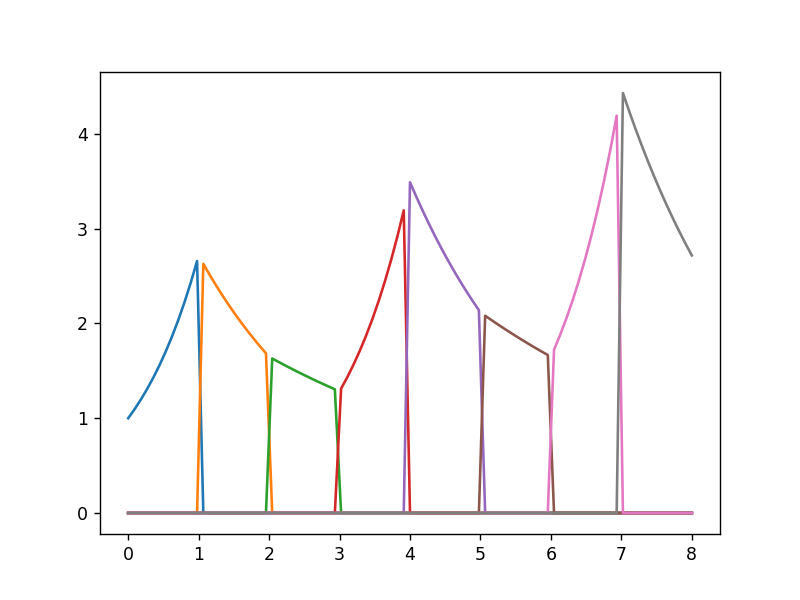

In [67]:
plt.plot(np.linspace(0, 8, 91), bfull_fn(1, [1, -0.5, -.25, 1, -.5, -.25, 1, -.5]).T)

In [71]:
eight_deriv_basis = [ca.jacobian(eb(t), t) for eb in eight_basis]

In [75]:
db = ca.vcat(eight_deriv_basis)

In [76]:
dbfns = ca.Function('dbfn', [t], [db])   ## WIP: some weirdness to do with how I've extracted this function out. 
                                         ## Need to do some code muddling to get this right.

In [72]:
edb_full = ca.hcat([ca.vcat([ebfn(ti) for ebfn in eight_deriv_basis]) for ti in np.linspace(0, 8, 91)])

TypeError: 'SX' object is not callable